In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

2025-05-30 15:41:45.178257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748619705.471120      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748619705.555664      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = "/kaggle/input/satellite-image-classification/data"

Class Distribution:
cloudy: 1500 images
desert: 1131 images
green_area: 1500 images
water: 1500 images


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


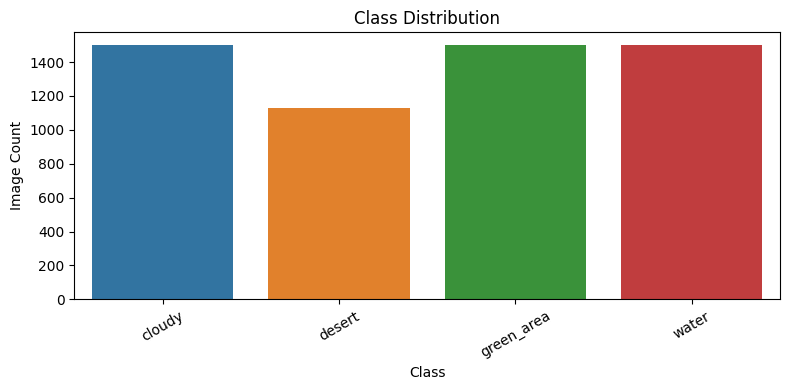

In [3]:

class_counts = {}

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len([
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f))
        ])

print("Class Distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

plt.figure(figsize=(8, 4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()



In [4]:
corrupt_images = []

for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    for img_file in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_file)
        try:
            img = Image.open(img_path)
            img.verify()
        except:
            corrupt_images.append(img_path)

print("Corrupt images found:", len(corrupt_images))

Corrupt images found: 0


In [5]:
batch_size = 32
height = 72
width = 128

In [6]:
#Loading the dataset and splitting into training and validation sets
train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1234,
    image_size=(height, width),
    batch_size=batch_size)

val = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1234,
    image_size=(height, width),
    batch_size=batch_size)

Found 5631 files belonging to 4 classes.
Using 4505 files for training.


2025-05-30 15:42:39.082398: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


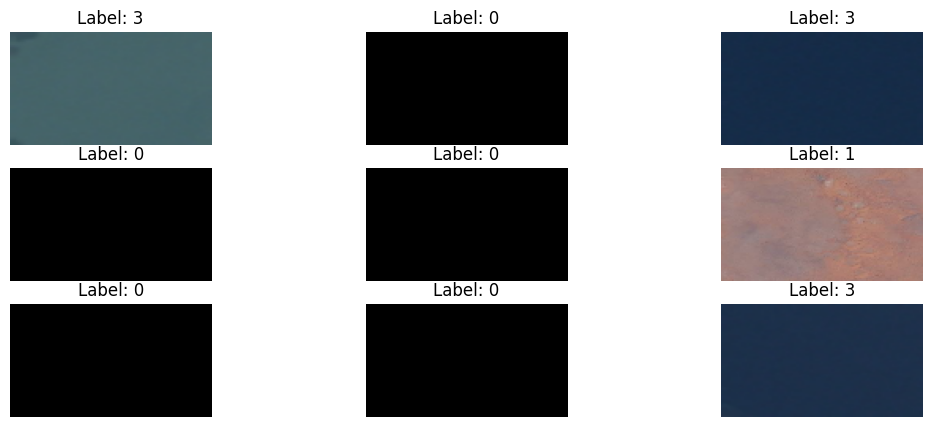

In [7]:
# Print the first images with their labels
plt.figure(figsize=(13, 5))
for i, (images, labels) in enumerate(train.take(1)):
    for j in range(9):
        ax = plt.subplot(3, 3, j + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title(f"Label: {labels[j].numpy()}")
        plt.axis("off")
plt.show()

In [8]:
amount = len(set(label for _, labels in train for label in labels.numpy()))
print(f"There are {amount} different Classes")

There are 4 different Classes


In [9]:
classes = {
    0: "cloudy",
    1: "desert",
    2: "water",
    3: "green_area"
}

In [10]:
# CNN model architecture
model = Sequential([
    layers.Input(shape=(height, width, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(amount)
])


In [11]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
epochs = 20
history = model.fit(
    train,
    validation_data=val,
    epochs=epochs
)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step - accuracy: 0.7563 - loss: 0.5612 - val_accuracy: 0.8623 - val_loss: 0.2933
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.9023 - loss: 0.2171 - val_accuracy: 0.9041 - val_loss: 0.2153
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 160ms/step - accuracy: 0.9136 - loss: 0.1849 - val_accuracy: 0.8819 - val_loss: 0.2100
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 0.9262 - loss: 0.1624 - val_accuracy: 0.9476 - val_loss: 0.1369
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 160ms/step - accuracy: 0.9340 - loss: 0.1498 - val_accuracy: 0.9387 - val_loss: 0.1636
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - accuracy: 0.9419 - loss: 0.1319 - val_accuracy: 0.9458 - val_loss: 0.1291
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.9458 - loss: 0.1143 - val_accuracy: 0.9254 - val_loss: 0.1454
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.9355 - loss: 0

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 72, 128, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 72, 128, 16)         │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 36, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 36, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 18, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 16, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,611,630 (13.78 MB)

 Trainable params: 1,203,876 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,407,754 (9.18 MB)

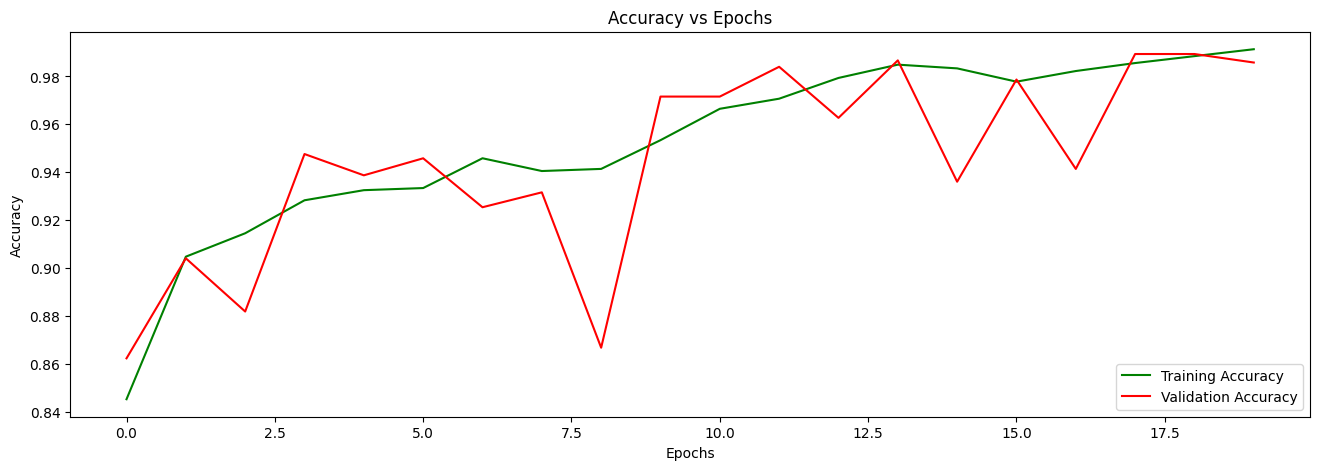

In [15]:
# accuracy and loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(16, 5))
plt.plot(epochs_range, accuracy, label='Training Accuracy', color='green')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='red')
plt.legend(loc='lower right')
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

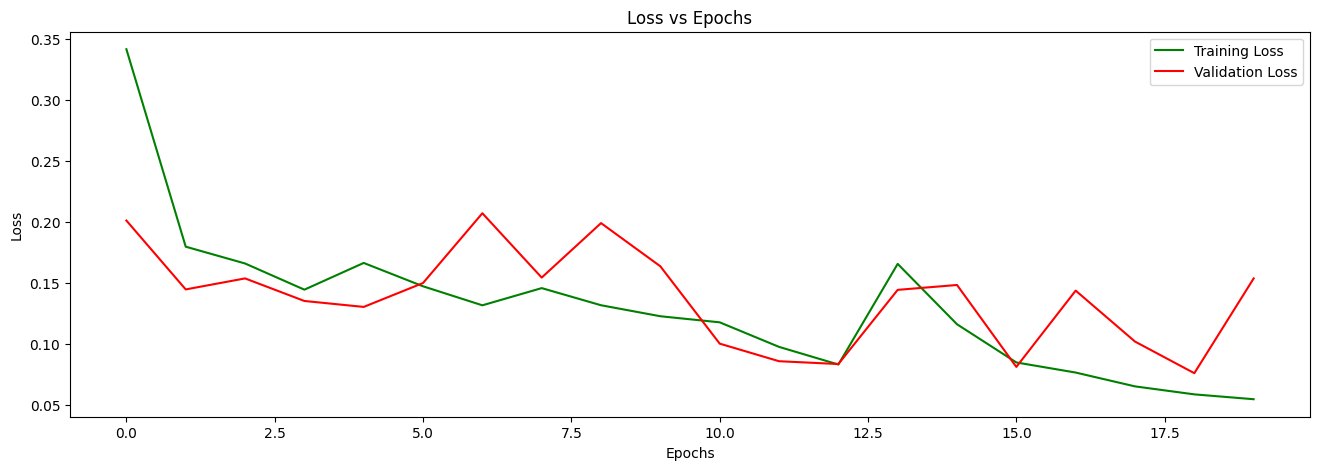

In [16]:
plt.figure(figsize=(16, 5))
plt.plot(epochs_range, loss, label='Training Loss', color='green')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
plt.legend(loc='upper right')
plt.title('Loss vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━

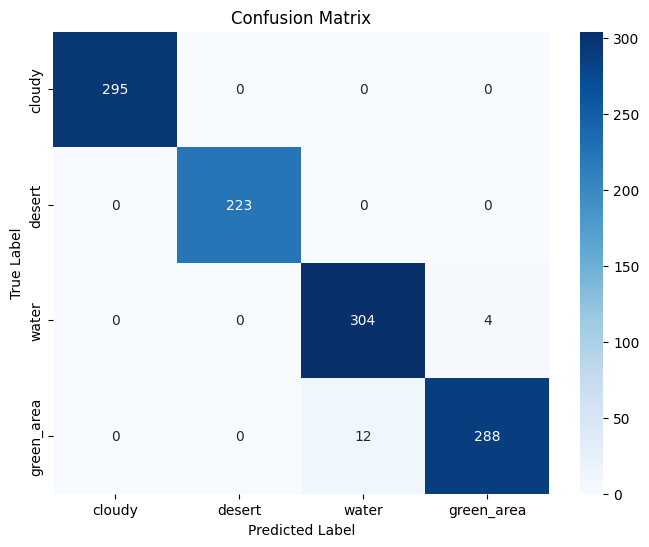

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


y_true = []
y_pred = []

for images, labels in val:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1).numpy()
    y_pred.extend(preds)
    y_true.extend(labels.numpy())


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[classes[i] for i in range(amount)],
            yticklabels=[classes[i] for i in range(amount)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [17]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[classes[i] for i in range(amount)]))

Classification Report:
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       295
      desert       1.00      1.00      1.00       223
       water       0.96      0.99      0.97       308
  green_area       0.99      0.96      0.97       300

    accuracy                           0.99      1126
   macro avg       0.99      0.99      0.99      1126
weighted avg       0.99      0.99      0.99      1126

